In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.3.0 cuda: True


In [2]:
%run PARAMETERS.py
NAME = 'APG'
PATH = NAME + '-1st-arch-200pts-20samples'
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
Ns = [120, 160, 200, 400, 600] 
Data_test = []
for i in range(10):
    data = torch.from_numpy(np.load('/home/hao/Research/apg_data/ncmm/rings_10size/' + 'ob_%d.npy' % (((i+1) * 10 + 20) * K) )).float()
    Data_test.append(data)

In [7]:
from model_operations import Init_models_test

models = Init_models_test(K, 
                        D, 
                        hidden_list=HIDDEN_LIST, 
                        RECON_SIGMA=RECON_SIGMA, 
                        CUDA=CUDA, 
                        device=DEVICE, 
                        lr=LEARNING_RATE, 
                        RESTORE=True, 
                        PATH=PATH, 
                        NAME=NAME)

In [8]:
from apg import APG_test
MCMC_STEPS = 15
S = 1000
B = 5
Test_Params = (K, S, B, DEVICE)
def Test_ALL(objective, data_g, mcmc_steps, Test_Params):
    Metrics = {'log_joint' : [], 'ess_mu' : [], 'ess_z' : []}
    (K, S, B, DEVICE) = Test_Params
    NUM_DATASETS = data_g.shape[0]
    NUM_BATCHES = int((NUM_DATASETS / B))
    for step in range(NUM_BATCHES):
        ob = data_g[step*B : (step+1)*B]
        ob = ob.repeat(S, 1, 1, 1)
        ob = ob.cuda().to(DEVICE)
        metrics = objective(models, ob, mcmc_steps, K)
        Metrics['ess_mu'].append(metrics['ess_mu'] / S)
        Metrics['ess_z'].append(metrics['ess_z'] / S)
        Metrics['log_joint'].append(metrics['log_joint'])

    return Metrics

In [9]:
for g, data_g in enumerate(Data_test):
    if g == 3:
        time_start = time.time()
        Metrics = Test_ALL(APG_test, data_g, MCMC_STEPS, Test_Params)
        time_end = time.time()
        print('group=%d (%ds)' % (g, (time_end - time_start)))
        for key in Metrics.keys():
            np.save('granular-%s-%s' % (Ns[g], key), torch.cat(Metrics[key], 0))

RuntimeError: CUDA out of memory. Tried to allocate 4.47 GiB (GPU 0; 10.91 GiB total capacity; 42.61 MiB already allocated; 508.81 MiB free; 4.58 GiB cached)

In [4]:
from testing import Eval
from viz_mc import Viz_MC
from apg import APG_test

BATCH_SIZE = 5
Viz_INTERVAL = 3

BOUND = 7
DATA_PTR = 4
Data = []


Ns= 200

evaluator = Eval(K, D, BATCH_SIZE, CUDA, DEVICE)
Metrics_sample = evaluator.Test_uniform(models, APG_test,  DATA_PTR, mcmc_steps=6, sample_size=1)


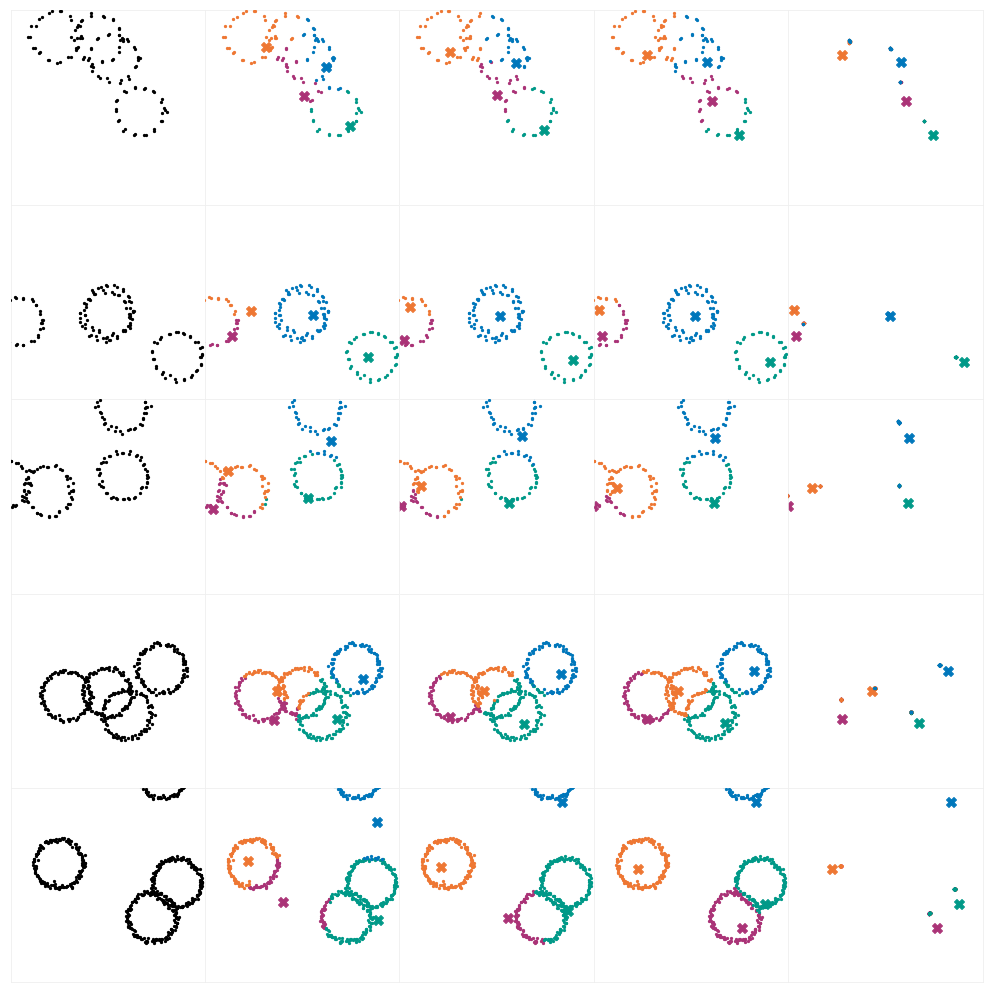

In [5]:
FS = 15
TITLE_FS = 20
OB_MS = 5.0
MU_MARKER = 'X'
MU_MS = 100
OPACITY = 1.0
COLORS = ['#AA3377',  '#009988', '#EE7733', '#0077BB']
b = -8
u = 8
l = -8
r = 8

visualizer = Viz_MC(K, Viz_INTERVAL, FS, TITLE_FS, OB_MS, MU_MARKER, MU_MS, OPACITY, BOUND, COLORS, b, u, l, r)
visualizer.Plot_chains(Metrics_sample['data'], Metrics_sample['samples'], Metrics_sample['recon'], filename='%d-%d' % (Ns, DATA_PTR))

In [ ]:
# L = 100
# Metrics_converge = evaluator.Test_uniform(models, APG_test, DATA_PTR, mcmc_steps=15, sample_size=L)
# visualizer.Plot_metrics(Metrics_converge['ll'], Metrics_converge['ess'], sample_size=L, filename='ncmm-metrics-1')

In [ ]:
DATA_PTR = 13
NUM_RUNS = 10
LogJs = []
ESSs = []
budgets = [[1000, 1], [500, 2], [200, 5], [100, 10], [50, 20], [20, 50], [10, 100], [5, 200]]
for r in range(NUM_RUNS):
    LogJ= []
    ESS = []
    for i, b in enumerate(budgets):
        samples = b[0]
        steps = b[1] - 1
        Metrics_converge = evaluator.Test_budget(models, APG_test, DATA_PTR, mcmc_steps=steps, sample_size=samples)
        LogJ.append(Metrics_converge['log_joint'].unsqueeze(0))
        ESS.append(Metrics_converge['ess'].unsqueeze(0) / samples)
    LogJs.append(torch.cat(LogJ, 0).unsqueeze(0))
    ESSs.append(torch.cat(ESS, 0).unsqueeze(0))
    %time print('run : %d' % r)

LogJs = torch.cat(LogJs, 0)
ESSs = torch.cat(ESSs, 0)

In [ ]:
np.save('budget-log-joint', LogJs.data.numpy())
np.save('budget-ess', ESSs.data.numpy())

In [ ]:
LogJs.shape

In [ ]:
import matplotlib.pyplot as plt
# COLORS = ['#0077BB', '#AA3377',  '#EE7733','#009988', 'BBBBBB']

for i in range(5):
    plt.plot(a.mean(0)[:,i])
    plt.show()

In [ ]:
a = np.load('budget-ll.npy')

In [ ]:
len(Metrics_converge['ll'])

In [ ]:
LLs[:, -1, 0] = LLs[:,-1, 0] + 150

In [ ]:
a[:, , 0]